# **Preprocessing of the CamVid Dataset**

The [Cambridge-driving Labeled Video Database (CamVid)](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) was the first video dataset with semantically annotated object classes, accompanied by metadata, specifically designed for semantic segmentation in driving scenarios. It consists of 701 frames, each with a resolution of 720 × 960 pixels, extracted from five video sequences recorded using fixed-position CCTV cameras mounted on a vehicle. Initially, the segmentation masks contained 32 classes, but they were later merged into 11 main categories (12 including the `void` class).  

The dataset does not have an official split; therefore, most studies use a partition of 367 images for training, 101 for validation, and 233 for testing. However, due to its small size, in this case, all 701 images and their corresponding masks are divided into 80% for training and 20% for validation to improve the model's performance in segmentation tasks. 

## **Imports**

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from google.colab import drive
from tqdm.auto import tqdm
from glob import glob
import cv2
import os

## **Parameters**

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
dataset_url = "https://github.com/lih627/CamVid"
dataset_dir = "/content/CamVid"
raw_dataset_dir = "/content/RawCamVid"
zip_dataset_path = "/content/drive/MyDrive/Datasets/CamVid.zip"
val_size = 0.2
SEED = 123

os.makedirs(dataset_dir, exist_ok=True)

## **Download the Dataset**

The dataset is available on various websites and GitHub repositories. However, in this [GitHub repository](https://github.com/lih627/CamVid), the images and their segmentation masks are provided in their original size (720 × 960 pixels) and have already been preprocessed.  

In [4]:
# Clone the repository
!git clone $dataset_url $raw_dataset_dir

Cloning into '/content/RawCamVid'...
remote: Enumerating objects: 2834, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2834 (delta 0), reused 1 (delta 0), pack-reused 2831 (from 1)
Receiving objects: 100% (2834/2834), 595.30 MiB | 22.90 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (2815/2815), done.


## **Preprocess the Dataset**

Since the dataset is already preprocessed, only the masks will be modified. Specifically, the `void` class, which has a value of 255, will be replaced with 0, and all other classes will be incremented by 1 to maintain consistency.

In [5]:
# Create the image and mask directories
image_dir = os.path.join(dataset_dir, "images")
mask_dir = os.path.join(dataset_dir, "masks")

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

In [7]:
# Copy all the images to the image directory
!cp -r {os.path.join(raw_dataset_dir, "CamVid_RGB/*")} $image_dir

In [8]:
# Preprocess the segmentation masks and save them
for path in tqdm(glob(os.path.join(raw_dataset_dir, "CamVidGray/*.png"))):
  filename = os.path.basename(path)

  mask = np.array(Image.open(path))
  mask = np.where(mask == 255, 0, mask + 1)
  mask = Image.fromarray(mask)

  mask.save(os.path.join(mask_dir, filename))

  0%|          | 0/701 [00:00<?, ?it/s]

In [12]:
# Split the image and mask paths into training and validation sets
image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

df_train, df_val = train_test_split(
    pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths}),
    test_size=val_size,
    random_state=SEED
)

df_train["split"] = "train"
df_val["split"] = "val"
df_data = pd.concat([df_train, df_val]).reset_index(drop=True)
df_data

,image_path,mask_path,split
0,/content/CamVid/images/0016E5_05880.png,/content/CamVid/masks/0016E5_05880_L.png,train
1,/content/CamVid/images/0016E5_01200.png,/content/CamVid/masks/0016E5_01200_L.png,train
2,/content/CamVid/images/0016E5_05520.png,/content/CamVid/masks/0016E5_05520_L.png,train
3,/content/CamVid/images/Seq05VD_f01020.png,/content/CamVid/masks/Seq05VD_f01020_L.png,train
4,/content/CamVid/images/0016E5_08115.png,/content/CamVid/masks/0016E5_08115_L.png,train
...,...,...,...
696,/content/CamVid/images/0006R0_f01740.png,/content/CamVid/masks/0006R0_f01740_L.png,val
697,/content/CamVid/images/0016E5_02100.png,/content/CamVid/masks/0016E5_02100_L.png,val
698,/content/CamVid/images/0001TP_007620.png,/content/CamVid/masks/0001TP_007620_L.png,val
699,/content/CamVid/images/0016E5_04800.png,/content/CamVid/masks/0016E5_04800_L.png,val


In [13]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  701 non-null    object
 1   mask_path   701 non-null    object
 2   split       701 non-null    object
dtypes: object(3)
memory usage: 16.6+ KB


In [14]:
# View the number of records for each dataset
df_data.split.value_counts()

,count
split,
train,560
val,141


The names of each class and their official colors can be found in the `camvid_data.py` file and at the following [link](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/data/label_colors.txt).  

In [15]:
# Define the classes and their respective colors
classes = {
    "void":       [0, 0, 0],
    "sky":        [128, 128, 128],
    "building":   [128, 0, 0],
    "pole":       [192, 192, 128],
    "road":       [128, 64, 128],
    "sidewalk":   [0, 0, 192],
    "tree":       [128, 128, 0],
    "signsymbol": [192, 128, 128],
    "fence":      [64, 64, 128],
    "car":        [64, 0, 128],
    "pedestrian": [64, 64, 0],
    "bicyclist":  [0, 128, 192]
}

In [16]:
# Save the DataFrame with the metadata
df_data.to_csv(os.path.join(dataset_dir, "metadata.csv"), index=False)

# Save the classes DataFrame
pd.DataFrame(classes.items(), columns=["name", "color"]).to_csv(
    os.path.join(dataset_dir, "classes.csv"), index=False
)

In [24]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Visualization Example**

In [17]:
# Function to plot images with their segmentation masks
def plot_image_masks(df, n_rows=3, alpha=0.6, random=True):
  class_colors = np.array(list(classes.values()))
  background_class = list(classes.keys()).index("void")

  image_paths = df.image_path.values
  mask_paths = df.mask_path.values

  indices = np.arange(len(image_paths))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(n_rows, 3, figsize=(3.25 * 3, 2.5 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = np.array(Image.open(image_paths[idx]).convert("RGB"))
    mask_cls = np.array(Image.open(mask_paths[idx]))
    mask_rgb = class_colors[mask_cls]

    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

  plt.tight_layout()
  plt.show()

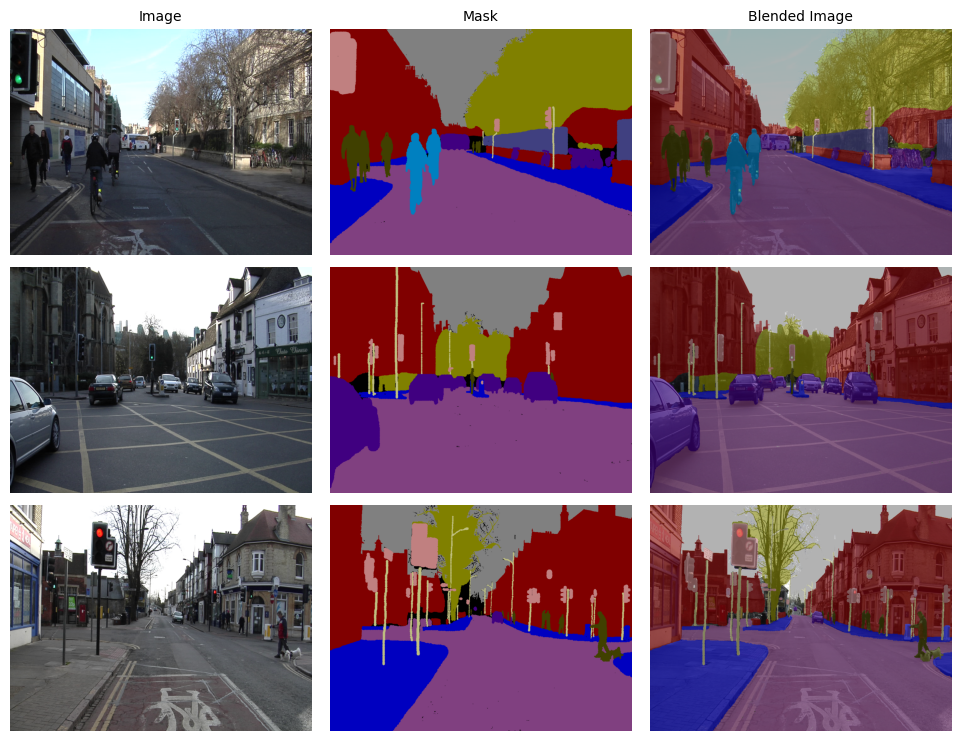

In [23]:
plot_image_masks(df_data[df_data.split == "train"])